In [ ]:
%matplotlib inline
import torch
import torch.nn as nn
import spacy
import gutenberg.acquire
import gutenberg.cleanup
import string
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from pprint import pprint

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

In [167]:
nlp = spacy.load('en_core_web_sm')
book = gutenberg.cleanup.strip_headers(gutenberg.acquire.load_etext(84)).strip()
doc = nlp(book)

In [197]:
class Net(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)
    
    def forward(self, input, previous_hidden):
        output, hidden = self.gru(input, previous_hidden)
        output = self.out(output)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return torch.rand(1, 1, self.hidden_size, device=device)

In [189]:
def input_tensor(chars, vocab):
    tensor = torch.zeros(len(chars) + 1, 1, len(vocab) + 1, device=device)
    tensor[0][0][len(vocab)] = 1 # START TOKEN
    for i in range(len(chars)):
         tensor[i + 1][0][vocab.index(chars[i])] = 1
    return tensor

def target_tensor(chars, vocab):
    indexes = [vocab.index(char) for char in chars]
    indexes.append(len(vocab)) # END TOKEN
    tensor = torch.tensor(indexes, device=device)
    tensor.unsqueeze_(-1)
    return tensor

In [190]:
def train(input, target, net, criterion, optimizer):
    hidden = net.init_hidden()
    net.zero_grad()
    loss = 0
    output, hidden = net(input, hidden)
    for pred, target in zip(output, target):
        loss += criterion(pred, target)
        
    loss.backward()
    optimizer.step()
    return loss.item()

In [194]:
def run_train(vocab, inputs, net, criterion, optimizer, plot_every=100):
    losses = []
    loss = 0
    
    for i, input in tqdm(list(enumerate(inputs))):
        loss += train(input_tensor(input, vocab), target_tensor(input, vocab), net, criterion, optimizer)

        if DEBUG: return

        if i % plot_every == 0:
            if LIVE_PLOT:
                 liveloss.update({'loss': loss / plot_every})
                 liveloss.draw()
                
            losses.append(loss / plot_every)
            loss = 0
        

    plt.figure()
    plt.plot(losses)
    
    return losses[-1]
    

In [198]:
vocab = list(set(book))
sents = list(doc.sents)[10:]
sents = filter(lambda sent: len(sent.text.split(' ')) > 4, sents)
sents = map(lambda sent: list(filter(lambda char: char != '\n', sent.text)), sents)
sents = list(sents)

199.9036990737915

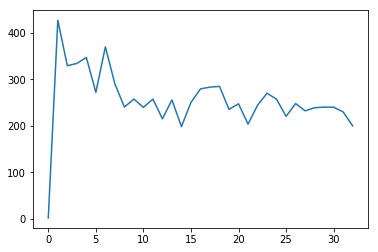

In [200]:
DEBUG = False
LIVE_PLOT = False
liveloss = PlotLosses()
net = Net(len(vocab) + 1, 100, len(vocab) + 1).to(device)
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)


run_train(vocab, sents, net, criterion, optimizer)

In [ ]:
def sample(vocab, net, max_length=100, beam_number=20):
    with torch.no_grad(): 
        output_sents = []
        beams = [(net.init_hidden(), [''])]
        
        for i in range(max_length):
            output_pairs = []
            new_hidden = []
            for beami, (hidden, result) in enumerate(beams):
                tensor = input_tensor(result[-1], vocab)
                output, hidden = net(tensor, hidden)
                
                output_pairs += map(lambda pair: (pair[0], pair[1].item(), beami), enumerate(output[0][0]))
                new_hidden.append(hidden)
            
            output_pairs.sort(key=lambda pair: pair[1], reverse=True)
            
            new_beams = []
            for outi, _outv, beami in output_pairs[:beam_number]:
                result = list(beams[beami][1])
                
                if outi == len(vocab): # END TOKEN
                    output_sents.append(result)
                else:
                    char = vocab[outi]
                    result.append(char)
                    
                    if i == max_length - 1:
                        output_sents.append(result)
                    else:
                        new_beams.append((new_hidden[beami].clone(), result))
            beams = new_beams
            
        return list(map(''.join, output_sents))
    
result = sample(vocab, net)
print('\n\n'.join(result))